# \#7 - Distributions

In this tutorial we'll cover how to create, attach, and manipulate distribution objects.

This interactive workshop tutorial covers many of the same topics as the corresponding online tutorials:

* [Distributions](http://phoebe-project.org/docs/2.3/tutorials/distributions.ipynb)
* [Advanced: Distribution Types](http://phoebe-project.org/docs/2.3/tutorials/distribution_propagation.ipynb)
* [Advanced: Distribution Propagation](http://phoebe-project.org/docs/2.3/tutorials/distribution_propagation.ipynb)
* [Advanced: Latex Representations in Distribution Plots](http://phoebe-project.org/docs/2.3/tutorials/latex_repr.ipynb)

# Setup

In [1]:
import phoebe
from phoebe import u,c

In [2]:
logger = phoebe.logger(clevel='WARNING')

In [3]:
b = phoebe.default_binary()
b.add_dataset('lc', compute_phases=phoebe.linspace(0,1,101))

<ParameterSet: 78 parameters | contexts: figure, constraint, compute, dataset>

# Adding Distributions

Distributions can be attached to most any FloatParameter in the Bundle. To see a list of these available parameters, we can call [b.get_adjustable_parameters](http://phoebe-project.org/docs/2.3/api/phoebe.frontend.bundle.Bundle.get_adjustable_parameters.md). Note the `exclude_constrained` option which defaults to True: we can set distributions on constrained parameters (for priors, for example), but those will not be able to be sampled from in the forward model or while fitting. We'll come back to this in the next tutorial when looking at priors.

In [4]:
b.get_adjustable_parameters()

<ParameterSet: 34 parameters | contexts: system, component, dataset>

The values of the [DistributionParameters](http://phoebe-project.org/docs/2.3/api/phoebe.parameters.DistributionParameter.md) are (distl)[http://phoebe-project.org/docs/2.3/api/phoebe.parameters.DistributionParameter.md] distribution objects -- the most common of which are conveniently available at the top-level of PHOEBE:

* [phoebe.gaussian](http://phoebe-project.org/docs/2.3/api/phoebe.gaussian.md)
* [phoebe.gaussian_around](http://phoebe-project.org/docs/2.3/api/phoebe.gaussian_around.md)
* [phoebe.uniform](http://phoebe-project.org/docs/2.3/api/phoebe.uniform.md)
* [phoebe.uniform_around](http://phoebe-project.org/docs/2.3/api/phoebe.uniform_around.md)

For an overview of the different available types as they apply in PHOEBE, see [Advanced: Distribution Types](http://phoebe-project.org/docs/2.3/tutorials/distribution_types.ipynb).

Now let's attach a gaussian distribution on the temperature of the primary star.

In [5]:
b.add_distribution(qualifier='teff', component='primary', 
                   value=phoebe.gaussian(6000,100), 
                   distribution='mydist')

<ParameterSet: 1 parameters>

We can now add additional distributions (to other parameters) with this same distribution label.  In addition to the single-distribution syntax above, multiple distributions can be attached in a single call as follows:

In [6]:
b.add_distribution({'requiv@primary': phoebe.gaussian(1, 0.2),
                    'requiv@secondary': phoebe.gaussian(1.2, 0.25),
                    'incl@binary': phoebe.uniform(88,90)},
                   distribution='mydist')

<ParameterSet: 3 parameters | components: primary, secondary, binary>

# Accesing & Plotting Distributions

The parameters we've created and attached are [DistributionParameters](http://phoebe-project.org/docs/2.3/api/phoebe.parameters.DistributionParameter.md) and live in `context='distribution'`, with all other tags matching the parameter they're referencing. For example, let's filter and look at the distributions we've added.

In [7]:
print(b.filter(context='distribution'))

ParameterSet: 4 parameters
         teff@mydist@distribution: <distl.gaussian loc=6000.0 scale=100.0 unit=K>
   requiv@primary@mydist@distr...: <distl.gaussian loc=1.0 scale=0.2 unit=solRad>
   requiv@secondary@mydist@dis...: <distl.gaussian loc=1.2 scale=0.25 unit=solRad>
         incl@mydist@distribution: <distl.uniform low=88.0 high=90.0 unit=deg>


In [8]:
print(b.get_parameter(context='distribution', qualifier='teff'))

Parameter: teff@mydist@distribution
                       Qualifier: teff
                     Description: distribution for the referenced parameter
                           Value: <distl.gaussian loc=6000.0 scale=100.0 unit=K>
                  Constrained by: 
                      Constrains: None
                      Related to: None



The "value" of the parameter, is the [distl](https://distl.readthedocs.io/) distributon object itself.

In [9]:
b.get_value(context='distribution', qualifier='teff')

<distl.gaussian loc=6000.0 scale=100.0 unit=K>

And because of that, we can call any method on the distl object, including plotting the distribution.

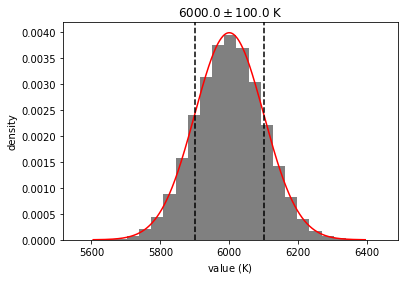

In [10]:
_ = b.get_value(context='distribution', qualifier='teff').plot(show=True)

If we want to see how multiple individual distributions interact and are correlated with each other via a corner plot, we can access the combined "distribution collection" from any number of `distribution` tags. This may not be terribly useful now, but is very useful when trying to create multivariate priors.

* [b.get_distribution_collection](http://phoebe-project.org/docs/2.3/api/phoebe.frontend.bundle.Bundle.get_distribution_collection.md)
* [b.plot_distribution_collection](http://phoebe-project.org/docs/2.3/api/phoebe.frontend.bundle.Bundle.plot_distribution_collection.md)

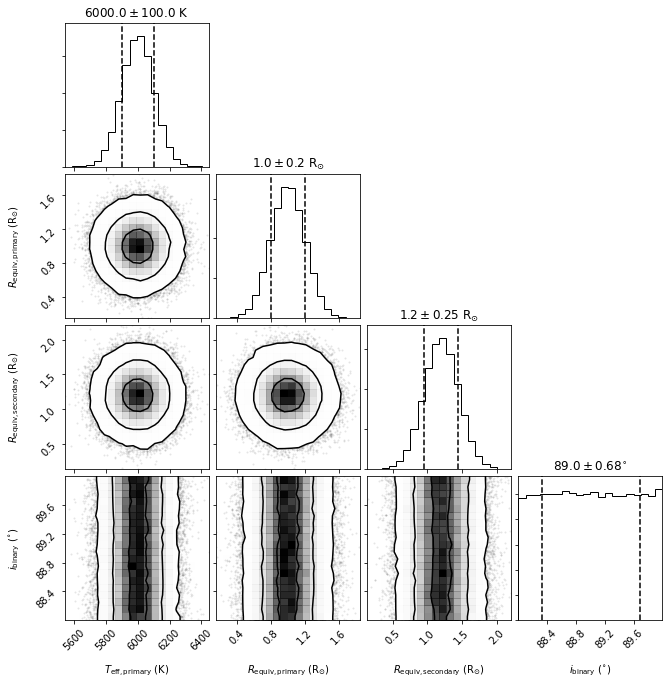

In [11]:
_ = b.plot_distribution_collection(distribution='mydist', show=True)

# Propagating Distributions through Constraints

We can pass a list of parameters (as twigs) to the `parameters` keyword argument to only plot a subset of the available parameters, but also to propagate distributions through constraints linking parameters together.

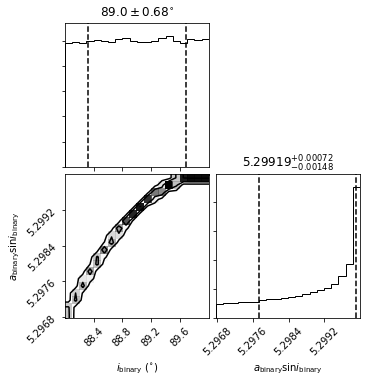

In [12]:
_ = b.plot_distribution_collection(distribution='mydist', 
                                   parameters=['incl@binary', 'asini@binary'],
                                   show=True)

# Propagating Distributions through Forward Model

Lastly, we can have PHOEBE automatically draw from a "distribution collection" multiple times and expose the distribution of the model itself.

In [13]:
print(b.get_parameter(qualifier='sample_from', context='compute'))

Parameter: sample_from@phoebe01@compute
                       Qualifier: sample_from
                     Description: distributions or solutions to use for sampling.  If pointing to a solution, adopt_solution(as_distributions=True, **kwargs) will be called to create a temporary distribution which will be removed automatically.  If all distributions are delta functions (face-values), sample_mode and sample_num will be ignored with a warning.
                           Value: []
                         Choices: mydist
                  Constrained by: 
                      Constrains: None
                      Related to: None



Once `sample_from` is set, `sample_num` and `sample_mode` are exposed as visible parameters

In [14]:
b.set_value('sample_from', value='mydist')

In [15]:
print(b.filter(qualifier='sample*'))

ParameterSet: 4 parameters
     sample_from@phoebe01@compute: ['mydist']
   sample_from_combine@phoebe0...: first
      sample_num@phoebe01@compute: 10
     sample_mode@phoebe01@compute: 1-sigma


Now when we call [run_compute](http://phoebe-project.org/docs/2.3/api/phoebe.frontend.bundle.Bundle.run_compute.md), 10 different instances of the forward model will be computed from 10 random draws from the "distribution collection" but only the median and 1-sigma uncertainties will be exposed in the model.

In [16]:
b.run_compute(irrad_method='none')

100%|██████████| 101/101 [00:17<00:00,  5.76it/s]


<ParameterSet: 8 parameters | qualifiers: times, comments, samples, sample_mode, fluxes, sampled_twigs, failed_samples, sampled_uniqueids>

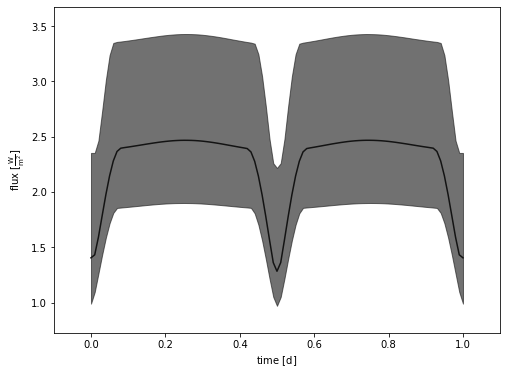

In [17]:
_ = b.plot(show=True)

# Exercises

Start from scratch, add constraints on both `sma@binary` and `incl@binary` and see how those propagate through to `asini@binary`.

Try setting distributions on parameters in Kepler's third law, flip constraints as necessary, and propagate the distributions through the Kepler's third law constraint.